In [649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal,chisquare,chi2_contingency
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import funcs
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [655]:
data = pd.read_csv("../objects/df_imputed_not_complete_874.csv", index_col=0)
data.head()

,RID,PTHAND,PTMARRY,PTEDUCAT,PTNOTRT,PTHOME,PTPLANG,PTETHCAT,PTRACCAT,age,...,RCT29,RCT3,RCT392,RCT4,RCT5,RCT6,RCT8,RCT9,apoe,DIAGNOSIS
1,2,2,1,16,1,1,1,2,5,74.333333,...,0.2,19,1.1,21,19,15,5.6,3.0,2,Control
2,3,1,1,18,1,3,1,2,5,81.250000,...,0.1,21,1.3,16,19,19,6.9,3.5,3,AZ
3,4,1,1,10,0,1,2,1,5,67.583333,...,0.1,16,1.2,23,18,25,6.0,2.9,2,MCI
4,5,1,1,16,1,1,1,2,5,73.666667,...,0.2,16,1.0,17,24,14,5.7,3.2,2,Control
5,6,1,1,13,1,1,1,2,5,80.416667,...,0.2,19,1.1,16,19,23,5.3,4.5,2,MCI


In [602]:
#data.drop(['RID'], axis = 1, inplace=True)

In [440]:
data['apoe'] = data['apoe'].replace({1: 0, 2: 0, 3: 1, 4: 1})
data['education_category'] = data['education_category'].astype(np.int64)
data['PTMARRY_bin'] = np.where(data['PTMARRY'] == 2, 1, 0)
data['PTMARRY_bin'] = data['PTMARRY_bin'].astype(np.int64)

In [604]:
data['apoe'] = data['apoe'].replace({1: 0, 2: 0, 3: 1, 4: 1})

## Filter-based feature selection

### KW test for continuous vars & Kramer's V for categorical vars

In [478]:
cat_features = [col for col in data.columns if (
    col.startswith("NX") or
    col.startswith("PX") or
    col.startswith("PT") or
    col.startswith("MH") or
    (col.startswith("GD") and col != "GDTOTAL") or
    col in ["mother", "father", "HMSCORE", "apoe", "apoe_2", "education_category"]
)]

In [444]:
cont_features = [col for col in data.columns if 
                 col not in cat_features and 
                col != "DIAGNOSIS"]

In [446]:
kr_stat = []
kr_p = []
for f in cont_features:
    groups = [data[f][data['DIAGNOSIS'] == cat] for cat in data['DIAGNOSIS'].unique()]
    kruskal_result = kruskal(*groups)
    kr_stat.append(kruskal_result.statistic)
    kr_p.append(kruskal_result.pvalue)


In [448]:
result_kw = pd.DataFrame({"feature": cont_features,
                         "stat": kr_stat,
                         "pvalue": kr_p})

In [510]:
result_kw[result_kw['pvalue'] < 0.01]

,feature,stat,pvalue
1,weight,11.788305,2.755511e-03
2,height,9.727670,7.720817e-03
7,VSPULSE,13.438741,1.207298e-03
9,LIMMTOTAL,436.018627,2.088133e-95
10,LDELTOTAL,543.719714,8.565729e-119
11,GDTOTAL,68.551723,1.300716e-15
14,HMT100,14.056448,8.865047e-04
19,HMT15,25.316244,3.181614e-06
20,HMT16,18.727201,8.579063e-05
29,HMT8,16.293852,2.896242e-04


In [452]:
cont_features_sig = result_kw[result_kw['pvalue'] < 0.01].feature.tolist()

In [480]:
cr = []

for f in cat_features:
    cont_tab = pd.crosstab(index=data['DIAGNOSIS'], columns=data[f])
    chi2, p, dof, expected = chi2_contingency(cont_tab)
    n = cont_tab.sum().sum()
    phi2 = chi2 / n
    r, k = cont_tab.shape
    cramers_v = np.sqrt(phi2 / min(r-1, k-1))
    cr.append(cramers_v)

In [482]:
result_kramer = pd.DataFrame({"feature": cat_features,
                         "Kramer": cr})
result_kramer = result_kramer.sort_values(by="Kramer", ascending=False)

In [484]:
result_kramer[result_kramer['Kramer'] > 0.1]

,feature,Kramer
59,GDMEMORY,0.398052
66,apoe,0.287770
32,MHPSYCH,0.192215
2,PTEDUCAT,0.167799
51,GDDROP,0.153349
31,NXGAIT,0.150544
4,PTHOME,0.132056
64,GDBETTER,0.128134
53,GDBORED,0.127018
63,GDHOPE,0.104368


In [486]:
cat_features_sig = result_kramer[result_kramer['Kramer'] > 0.1].feature.tolist()

In [488]:
feat = cont_features_sig + cat_features_sig

### Model after feature selection

In [606]:
outcome = data['DIAGNOSIS']
outcome = outcome.replace({"Control": 0,
                  "MCI": 1,
                  "AZ": 2})

In [608]:
data.drop('DIAGNOSIS', axis = 1, inplace=True)

In [229]:
X, X_test, y, y_test = train_test_split(data[feat], outcome, test_size=0.2, random_state=43)

In [231]:
smote_over = SMOTE(random_state=44)
X, y = smote_over.fit_resample(X, y)

In [233]:
best_params_feat_selection = {"iterations": 1800, 
                              "learning_rate": 0.20649746303659136, 
                              "l2_leaf_reg": 4.37841702433753, 
                              "bagging_temperature": 1.6766419657563723, 
                              "random_strength": 1.9555985333019168, 
                              "depth": 7, 
                              "min_data_in_leaf": 91, 
                              'random_seed': 42,
                              'loss_function': "MultiClass",
                              "colsample_bylevel": 0.9759404466998405}

In [235]:
final_model = CatBoostClassifier(**best_params_feat_selection, verbose=False)

In [237]:
final_model.fit(X, y)

In [239]:
predictions = final_model.predict(X_test)
predictions_proba = final_model.predict_proba(X_test)

In [241]:
funcs.metrics_merged(y_test, predictions, predictions_proba)

,Class,Recall,Precision,Specificity,NPV,AUC
0,Control,0.906977,0.812500,0.931818,0.968504,0.986258
1,MCI,0.783505,0.844444,0.820513,0.752941,0.900211
2,AD,0.714286,0.675676,0.914286,0.927536,0.923265


In [422]:
confusion_matrix(y_test, predictions)

array([[39,  4,  0],
       [ 9, 76, 12],
       [ 0, 10, 25]], dtype=int64)

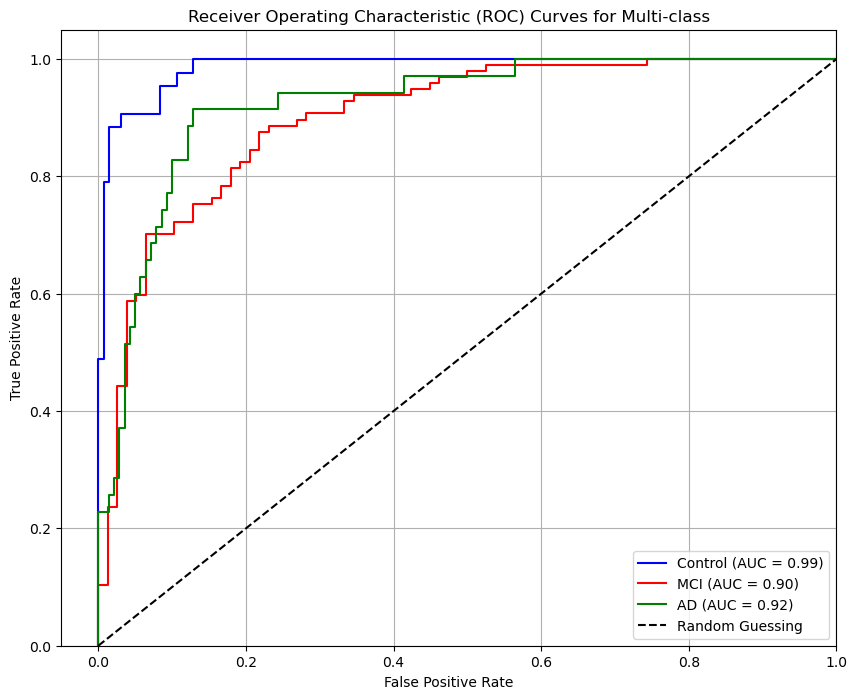

In [188]:
n_classes = len(np.unique(y_test))
class_labels = ["Control", "MCI", "AD"]
colors = ['blue', 'red', 'green']  # Define colors for the ROC curves

# Create a plot for ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test == i, predictions_proba[:, i])  # True binary labels for each class
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line for random guessing
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### PCA

In [610]:
feat = ['NXGAIT', "MHPSYCH", "GDDROP", "GDBORED", "GDMEMORY", "GDBETTER", "GDTOTAL", "HMT15", "HMT8","LDELTOTAL", "LIMMTOTAL", "apoe", "PTEDUCAT"]

In [612]:
data_feat = data[feat]

In [614]:
pipeline = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=2)),])

In [616]:
pca_data = pd.DataFrame(
    pipeline.fit_transform(data_feat),
    columns=["PC1", "PC2"],
    index=data_feat.index
)
pca_data['outcome'] = outcome.replace({0: "Control", 1:"MCI", 2:"AZ"})
pca_step = pipeline.steps[1][1]

### MCI overlaps with both Control and AD

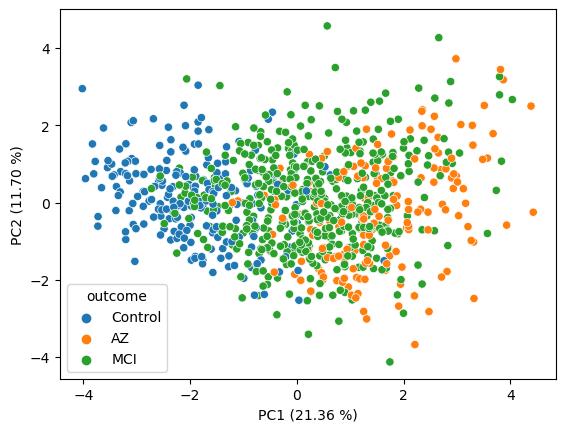

In [736]:
g = sns.scatterplot(data=pca_data, x="PC1", y="PC2", hue="outcome")


# Add variance explained by the
g.set_xlabel(f"PC1 ({pca_step.explained_variance_ratio_[0]*100:.2f} %)")
g.set_ylabel(f"PC2 ({pca_step.explained_variance_ratio_[1]*100:.2f} %)")

plt.savefig("pics/PCA_with_loadings.tiff", dpi=300)
plt.show()

In [620]:
pca_MCI = pca_data[pca_data["outcome"] == "MCI"]

D:\soft\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\soft\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\soft\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\soft\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
 

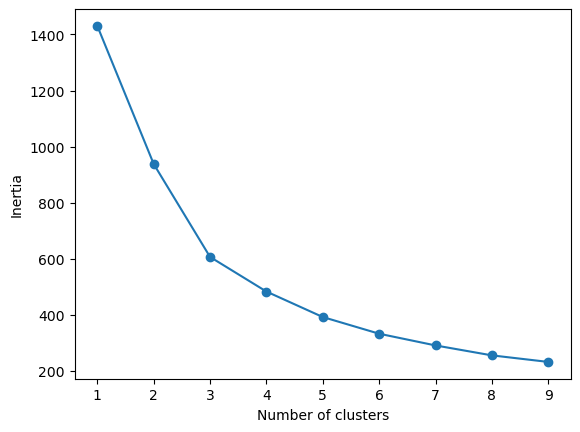

In [738]:
# Calculate inertia for different k values
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_MCI.iloc[:,0:2])
    inertias.append(kmeans.inertia_)

# Plot inertia to find the elbow
plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig("pics/Inertia.tiff", dpi=300)
plt.show()

In [622]:
gmm = GaussianMixture(n_components=3, covariance_type='tied')
labels = gmm.fit_predict(pca_MCI.iloc[:,0:2])

D:\soft\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [624]:
labels_MCI = np.where(labels == 0, "MCI1", np.where(labels == 1, "MCI2", "MCI3"))

In [626]:
pca_data["cluster"] = pca_data["outcome"]
pca_data.loc[pca_data["outcome"] == "MCI", "cluster"] = labels_MCI

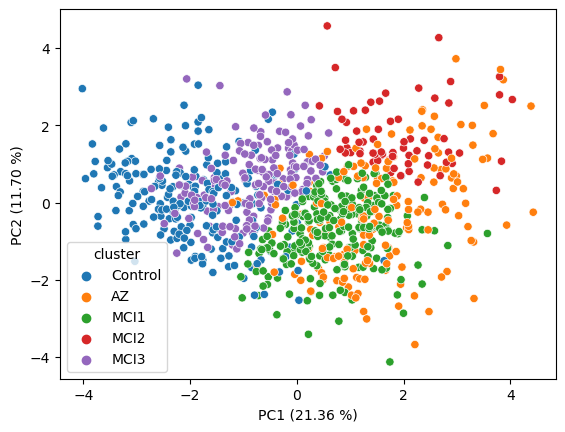

In [740]:
g = sns.scatterplot(data=pca_data, x="PC1", y="PC2", hue="cluster")


# Add variance explained by the
g.set_xlabel(f"PC1 ({pca_step.explained_variance_ratio_[0]*100:.2f} %)")
g.set_ylabel(f"PC2 ({pca_step.explained_variance_ratio_[1]*100:.2f} %)")

plt.savefig("pics/PCA_with_loadings_2.tiff", dpi=300)
plt.show()

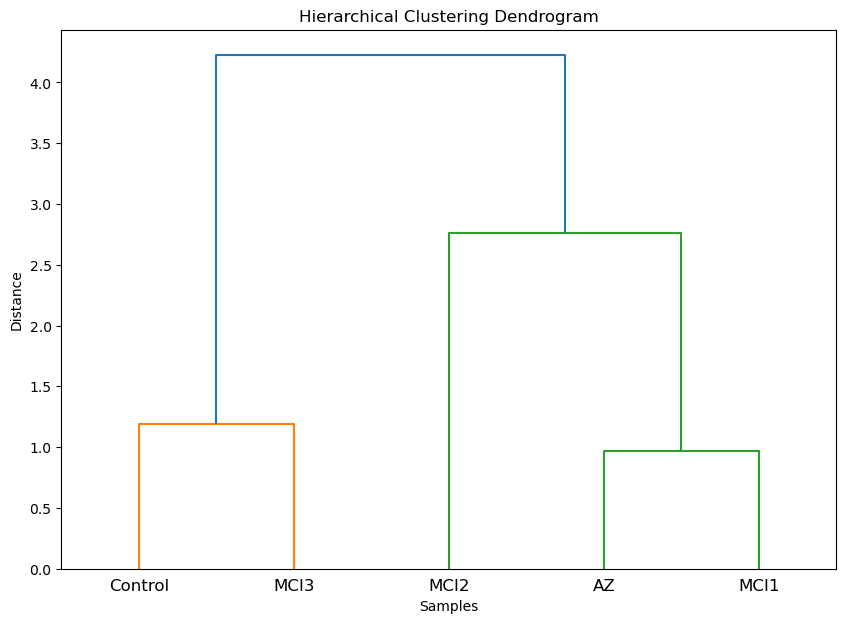

In [742]:
grouped_data = pca_data.groupby('cluster')[['PC1', 'PC2']].mean()
Z = linkage(grouped_data, method='ward')

# Create a dendrogram to visualize the clustering
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=grouped_data.index)  # 'outcome' includes AZ, Control, MCI1, MCI2, MCI3
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.savefig("pics/dendrogram.tiff", dpi=300)
plt.show()

In [657]:
data_feat_cluster = data_feat.copy()
data_feat_cluster["cluster"] = pca_data["cluster"]
data_feat_cluster['RID'] = data['RID']

In [659]:
data_feat_cluster = data_feat_cluster[data_feat_cluster['cluster'].isin(["MCI1", "MCI2", "MCI3"])]

In [661]:
data_feat_cluster['cluster'] = data_feat_cluster['cluster'].replace({'MCI1': 'MCI_AD', 'MCI3':'MCI_Healthy', 'MCI2': 'MCI_Middle'})

In [642]:
for var in cont_features_sig:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cluster', y=var, data=data_feat_cluster)
    plt.title(f'Boxplot of {var} by MCI1, MCI2, MCI3')
    plt.show()

    # Perform statistical test (ANOVA or Kruskal-Wallis)
    mci1_data = data_feat_cluster[data_feat_cluster['cluster'] == 'MCI_Middle'][var]
    mci2_data = data_feat_cluster[data_feat_cluster['cluster'] == 'MCI_AD'][var]
    mci3_data = data_feat_cluster[data_feat_cluster['cluster'] == 'MCI_Healthy'][var]


    stat, p_value = kruskal(mci1_data, mci2_data, mci3_data)
    print(f"Kruskal-Wallis for {var}: H = {stat:.3f}, p = {p_value:.3f}")

ValueError: Could not interpret input 'weight'

<Figure size 600x400 with 0 Axes>

In [666]:
ids_to_exclude_AD = data_feat_cluster[data_feat_cluster['cluster'] == "MCI_AD"]['RID'].to_list()
ids_to_exclude_Healthy = data_feat_cluster[data_feat_cluster['cluster'] == "MCI_Healthy"]['RID'].to_list()
ids_to_exclude_Middle = data_feat_cluster[data_feat_cluster['cluster'] == "MCI_Middle"]['RID'].to_list()

In [669]:
data_no_MCI_AD = data[~data['RID'].isin(ids_to_exclude_AD)].copy()
data_no_MCI_Healthy = data[~data['RID'].isin(ids_to_exclude_Healthy)].copy()
data_no_MCI_Middle = data[~data['RID'].isin(ids_to_exclude_Middle)].copy()

In [678]:
best_params = {"iterations": 1900, 
               "learning_rate": 0.0980771768328211, 
               "l2_leaf_reg": 1.0838481536171913, 
               "bagging_temperature": 0.7706864112026646, 
               "random_strength": 2.283941634872743, 
               "depth": 8, 
               'random_seed': 42,
               "min_data_in_leaf": 72}

## No MCI Healthy subgroup

In [674]:
outcome = data_no_MCI_Healthy['DIAGNOSIS'].copy()
outcome = outcome.replace({"Control": 0,
                  "MCI": 1,
                  "AZ": 2})
data_no_MCI_Healthy.drop(['RID', 'DIAGNOSIS'], axis = 1, inplace=True)

In [681]:
X, X_test, y, y_test = train_test_split(data_no_MCI_Healthy[feat], outcome, test_size=0.2, random_state=43)

In [684]:
smote_over = SMOTE(random_state=44)
X, y = smote_over.fit_resample(X, y)

In [687]:
final_model = CatBoostClassifier(**best_params, verbose=False)

In [690]:
final_model.fit(X, y)

In [692]:
predictions = final_model.predict(X_test)
predictions_proba = final_model.predict_proba(X_test)

In [694]:
funcs.metrics_merged(y_test, predictions, predictions_proba)

,Class,Recall,Precision,Specificity,NPV,AUC
0,Control,0.883721,0.926829,0.969697,0.950495,0.984026
1,MCI,0.694915,0.683333,0.771084,0.780488,0.831530
2,AD,0.650000,0.634146,0.852941,0.861386,0.877206


## No MCI Middle subgroup

In [700]:
outcome = data_no_MCI_Middle['DIAGNOSIS']
outcome = outcome.replace({"Control": 0,
                  "MCI": 1,
                  "AZ": 2})
data_no_MCI_Middle.drop(['RID', 'DIAGNOSIS'], axis = 1, inplace=True)

In [703]:
X, X_test, y, y_test = train_test_split(data_no_MCI_Middle[feat], outcome, test_size=0.2, random_state=43)

In [706]:
smote_over = SMOTE(random_state=44)
X, y = smote_over.fit_resample(X, y)

In [709]:
final_model.fit(X, y)

In [711]:
predictions = final_model.predict(X_test)
predictions_proba = final_model.predict_proba(X_test)

In [713]:
funcs.metrics_merged(y_test, predictions, predictions_proba)

,Class,Recall,Precision,Specificity,NPV,AUC
0,Control,0.894737,0.894737,0.967742,0.967742,0.987054
1,MCI,0.776471,0.835443,0.831169,0.771084,0.870130
2,AD,0.769231,0.666667,0.878049,0.923077,0.904107


## No MCI AD subgroup

In [717]:
outcome = data_no_MCI_AD['DIAGNOSIS']
outcome = outcome.replace({"Control": 0,
                  "MCI": 1,
                  "AZ": 2})
data_no_MCI_AD.drop(['RID', 'DIAGNOSIS'], axis = 1, inplace=True)

In [720]:
X, X_test, y, y_test = train_test_split(data_no_MCI_AD[feat], outcome, test_size=0.2, random_state=43)

In [723]:
smote_over = SMOTE(random_state=44)
X, y = smote_over.fit_resample(X, y)

In [726]:
final_model.fit(X, y)

In [728]:
predictions = final_model.predict(X_test)
predictions_proba = final_model.predict_proba(X_test)

In [730]:
funcs.metrics_merged(y_test, predictions, predictions_proba)

,Class,Recall,Precision,Specificity,NPV,AUC
0,Control,0.812500,0.866667,0.924051,0.890244,0.963871
1,MCI,0.833333,0.740741,0.822785,0.890411,0.919304
2,AD,0.838710,0.928571,0.979167,0.949495,0.983535
